In [1]:
import numpy as np
from scipy.stats import gaussian_kde
import pandas as pd
import matplotlib.pyplot as plt

import ipywidgets as widgets
from IPython.display import display

In [ ]:
def bhattacharyya_distance(P1_samples, P2_samples, num_samples=1000, bandwidth=0.1):
    
    kde1 = gaussian_kde(P1_samples.T, bw_method=bandwidth)
    kde2 = gaussian_kde(P2_samples.T, bw_method=bandwidth)
    
    min_val = min(np.min(P1_samples), np.min(P2_samples))
    max_val = max(np.max(P1_samples), np.max(P2_samples))
    
    grid_points = np.linspace(min_val, max_val, num_samples)
    
    p1_values = kde1(grid_points)
    p2_values = kde2(grid_points)
    
    bhattacharyya_coef = np.sum(np.sqrt(p1_values * p2_values)) / num_samples
    
    distance = -np.log(bhattacharyya_coef)
    
    return distance


def normalize_data(data):

    return (data - np.mean(data, axis=0)) / np.std(data, axis=0)

def extract_state_action_pairs(data):

    state_action_pairs = []
    for trajectory in data.keys():
        trajectory_data = data[trajectory]
        
        states = np.vstack([trajectory_data['s'], trajectory_data['e'], trajectory_data['dtheta'], 
                            trajectory_data['vx'], trajectory_data['vy']]).T
        
        actions = np.vstack([trajectory_data['steering'], trajectory_data['throttle']]).T
        
        state_action_pairs.extend(zip(states, actions))
    
    return np.array([pair[0] for pair in state_action_pairs]), np.array([pair[1] for pair in state_action_pairs])

def estimate_joint_kde(states, actions, bandwidth=0.1):

    state_action_data = np.hstack([states, actions])
    
    kde_joint = gaussian_kde(state_action_data.T, bw_method=bandwidth)
    
    return kde_joint

# Compute conditional probability P(A|S) = P(S, A) / P(S)
def conditional_probability(kde_joint, states, actions, kde_states, num_samples=1000, subset_size=500):

    joint_data = np.hstack([states, actions]) 
    
    subset_indices = np.random.choice(joint_data.shape[0], subset_size, replace=False)
    joint_data_subset = joint_data[subset_indices]
    
    joint_prob = kde_joint(joint_data_subset.T)  
    
    sampled_states = joint_data_subset[:, :-actions.shape[1]]  
    p_s_subset = kde_states(sampled_states.T) 
    
    # Conditional probability P(A|S) = P(S, A) / P(S)
    p_a_given_s = joint_prob / p_s_subset  
    
    return p_a_given_s, sampled_states


In [80]:
plot_bandwidths = False
plot_dist = True

# Load expert data
expert_data = pd.read_feather('all_trajectories.feather').to_dict()
states_expert, actions_expert = extract_state_action_pairs(expert_data)

# Normalize expert data
states_expert = normalize_data(states_expert)
actions_expert = normalize_data(actions_expert)

# Load controller-generated data (Pure Pursuit controller samples)
controller_data = pd.read_feather('model18_dist.feather').to_dict()
states_controller, actions_controller = extract_state_action_pairs(controller_data)

# Normalize controller data
states_controller = normalize_data(states_controller)
actions_controller = normalize_data(actions_controller)

# Load controller-generated data (Pure Pursuit controller samples)
controller_data_pure_pursuit = pd.read_feather('model18_dist_pure_pursuit.feather').to_dict()
states_controller_pure_pursuit, actions_controller_pure_pursuit = extract_state_action_pairs(controller_data_pure_pursuit)

# Normalize Pure Pursuit controller data
states_controller_pure_pursuit = normalize_data(states_controller_pure_pursuit)
actions_controller_pure_pursuit = normalize_data(actions_controller_pure_pursuit)

# Estimate joint KDEs for each dataset
kde_joint_expert = estimate_joint_kde(states_expert, actions_expert, bandwidth=0.1)
kde_joint_controller = estimate_joint_kde(states_controller, actions_controller, bandwidth=0.1)
kde_joint_pure_pursuit = estimate_joint_kde(states_controller_pure_pursuit, actions_controller_pure_pursuit, bandwidth=0.1)

# Estimate KDE for states (marginal distributions)
kde_states_expert = gaussian_kde(states_expert.T, bw_method=0.1)
kde_states_controller = gaussian_kde(states_controller.T, bw_method=0.1)
kde_states_pure_pursuit = gaussian_kde(states_controller_pure_pursuit.T, bw_method=0.1)

# Compute conditional probabilities and corresponding states
p_a_given_s_expert, sampled_states_expert = conditional_probability(kde_joint_expert, states_expert, actions_expert, kde_states_expert)
p_a_given_s_controller, sampled_states_controller = conditional_probability(kde_joint_controller, states_controller, actions_controller, kde_states_controller)
p_a_given_s_pure_pursuit, sampled_states_pure_pursuit = conditional_probability(kde_joint_pure_pursuit, states_controller_pure_pursuit, actions_controller_pure_pursuit, kde_states_pure_pursuit)


In [89]:

# Actions
distance_actions_expert_controller = bhattacharyya_distance(p_a_given_s_expert, p_a_given_s_controller)
print(f"Bhattacharyya distance for Expert vs Controller Actions: {distance_actions_expert_controller}")

distance_actions_expert_pure = bhattacharyya_distance(p_a_given_s_expert, p_a_given_s_pure_pursuit)
print(f"Bhattacharyya distance for Expert vs PP Actions: {distance_actions_expert_pure}")


Bhattacharyya distance for Expert vs Controller Actions: 3.5594704616939783
Bhattacharyya distance for Expert vs PP Actions: 3.5837576999499072


In [ ]:

def plot_conditional_probability(p_a_given_s_expert, p_a_given_s_controller, p_a_given_s_pure_pursuit,
                                 sampled_states_expert, sampled_states_controller, sampled_states_pure_pursuit,
                                 state_index=0, plot_type='line', title='Conditional Probability of Actions Given States',
                                 xlabel='State', ylabel='P(A|S)', figsize=(10, 6)):

    # Get the state for the chosen index (e.g., 0 for s, 1 for e, etc.)
    x_expert = sampled_states_expert[:, state_index]
    x_controller = sampled_states_controller[:, state_index]
    x_pure_pursuit = sampled_states_pure_pursuit[:, state_index]
    
    plt.figure(figsize=figsize)
    
    if plot_type == 'line':
        # Line plot for Expert
        plt.plot(x_expert, p_a_given_s_expert, label="Expert", color='blue')
        
        # Line plot for Controller
        plt.plot(x_controller, p_a_given_s_controller, label="Controller", color='green')
        
        # Line plot for Pure Pursuit
        plt.plot(x_pure_pursuit, p_a_given_s_pure_pursuit, label="Pure Pursuit", color='red')
    
    elif plot_type == 'scatter':
        # Scatter plot for Expert
        plt.scatter(x_expert, p_a_given_s_expert, label="Expert", color='blue', alpha=0.5)
        
        # Scatter plot for Controller
        plt.scatter(x_controller, p_a_given_s_controller, label="Controller", color='green', alpha=0.5)
        
        # Scatter plot for Pure Pursuit
        plt.scatter(x_pure_pursuit, p_a_given_s_pure_pursuit, label="Pure Pursuit", color='red', alpha=0.5)

    # Add title, labels, and legend
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.legend(loc='best', fontsize=12)
    
    # Show the plot
    plt.tight_layout()
    plt.grid(True)
    plt.show()


def update_plot(state_index, plot_type):

    plot_conditional_probability(
        p_a_given_s_expert, p_a_given_s_controller, p_a_given_s_pure_pursuit,
        sampled_states_expert, sampled_states_controller, sampled_states_pure_pursuit,
        state_index=state_index, plot_type=plot_type, title='P(A|S) Conditional Probability', xlabel='State', ylabel='P(A|S)'
    )

state_selector = widgets.Dropdown(
    options=[('State 1 (s)', 0), ('State 2 (e)', 1), ('State 3 (dtheta)', 2), ('State 4 (vx)', 3),('State 5 (vy)', 4)], 
    value=0, 
    description='State:',
)

plot_type_selector = widgets.Dropdown(
    options=[('Line', 'line'), ('Scatter', 'scatter')],
    value='line',  
    description='Plot Type:',
)

widgets.interactive(update_plot, state_index=state_selector, plot_type=plot_type_selector)


interactive(children=(Dropdown(description='State:', options=(('State 1 (s)', 0), ('State 2 (e)', 1), ('State …

KeyboardInterrupt: 

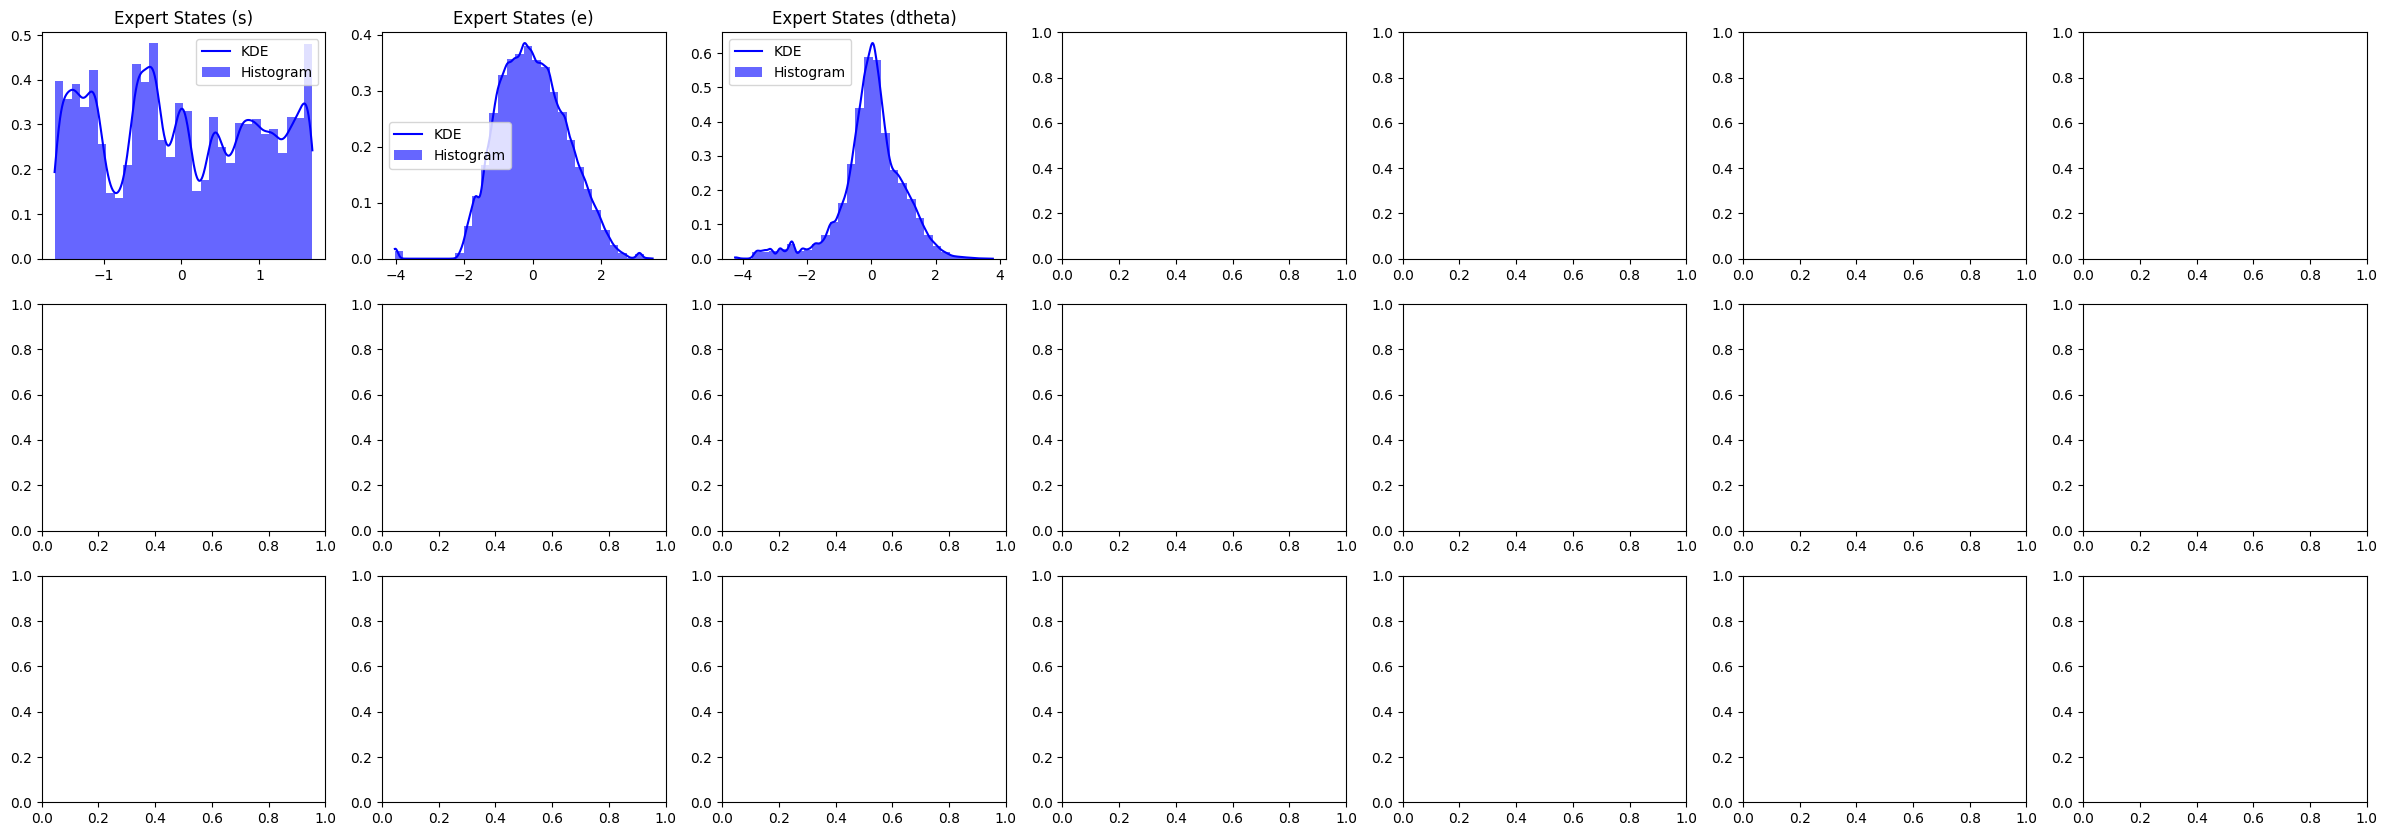

In [26]:
def plot_kde(data, ax, label="Data", color='g'):
    # Create the KDE for the data
    kde = gaussian_kde(data.T)
    x = np.linspace(data.min(), data.max(), 1000)
    
    # Plot the KDE curve
    ax.plot(x, kde(x), label="KDE", color='blue')
    
    # Plot the histogram (normalized to density)
    ax.hist(data, bins=30, density=True, alpha=0.6, color=color, label="Histogram")
    
    # Set the labels and title
    ax.legend()
    ax.set_title(label)

if plot_dist == True:
    fig, axes = plt.subplots(3, 7, figsize=(30, 10))  # Create a 3x7 grid of subplots

    # Ensure axes are accessed correctly, using 2D indexing.
    plot_kde(states_expert[:, 0], axes[0, 0], "Expert States (s)", color='blue')
    plot_kde(states_expert[:, 1], axes[0, 1], "Expert States (e)", color='blue')
    plot_kde(states_expert[:, 2], axes[0, 2], "Expert States (dtheta)", color='blue')
    plot_kde(states_expert[:, 3], axes[0, 3], "Expert States (vx)", color='blue')
    plot_kde(states_expert[:, 4], axes[0, 4], "Expert States (vy)", color='blue')
    plot_kde(actions_expert[:, 0], axes[0, 5], "Expert Actions (steering)", color='blue')
    plot_kde(actions_expert[:, 1], axes[0, 6], "Expert Actions (throttle)", color='blue')

    plot_kde(states_controller[:, 0], axes[1, 0], "Controller States (s)", color='green')
    plot_kde(states_controller[:, 1], axes[1, 1], "Controller States (e)", color='green')
    plot_kde(states_controller[:, 2], axes[1, 2], "Controller States (dtheta)", color='green')
    plot_kde(states_controller[:, 3], axes[1, 3], "Controller States (vx)", color='green')
    plot_kde(states_controller[:, 4], axes[1, 4], "Controller States (vy)", color='green')
    plot_kde(actions_controller[:, 0], axes[1, 5], "Controller Actions (steering)", color='green')
    plot_kde(actions_controller[:, 1], axes[1, 6], "Controller Actions (throttle)", color='green')

    plot_kde(states_controller_pure_pursuit[:, 0], axes[2, 0], "Controller Pure Pursuit States (s)", color='red')
    plot_kde(states_controller_pure_pursuit[:, 1], axes[2, 1], "Controller Pure Pursuit States (e)", color='red')
    plot_kde(states_controller_pure_pursuit[:, 2], axes[2, 2], "Controller Pure Pursuit States (dtheta)", color='red')
    plot_kde(states_controller_pure_pursuit[:, 3], axes[2, 3], "Controller Pure Pursuit States (vx)", color='red')
    plot_kde(states_controller_pure_pursuit[:, 4], axes[2, 4], "Controller Pure Pursuit States (vy)", color='red')
    plot_kde(actions_controller_pure_pursuit[:, 0], axes[2, 5], "Controller Pure Pursuit Actions (steering)", color='red')
    plot_kde(actions_controller_pure_pursuit[:, 1], axes[2, 6], "Controller Pure Pursuit Actions (throttle)", color='red')

    plt.tight_layout()  # Automatically adjust layout to prevent overlap
    plt.show()

# 2. **Bandwidth Sensitivity**: Plot KDE with different bandwidths

def bandwidth_sensitivity(data, ax, label="Data", bandwidths=[0.1, 0.5, 1.0]):
    """
    Plot KDEs with different bandwidths on a single axis.
    """
    # Loop over each bandwidth value
    for bw in bandwidths:
        kde = gaussian_kde(data.T, bw_method=bw)
        x = np.linspace(data.min(), data.max(), 1000)
        ax.plot(x, kde(x), label=f"Bandwidth {bw}")
    
    # Plot the histogram (normalized to density)
    ax.hist(data, bins=30, density=True, alpha=0.6, color='g', label="Histogram")
    
    # Set the labels and title
    ax.legend()
    ax.set_title(label)

if plot_bandwidths == True:

    fig, axes = plt.subplots(3, 7, figsize=(30, 10))

    bandwidths = [0.1, 0.5, 1.0]

    # Plot the bandwidth sensitivity for expert states and actions
    bandwidth_sensitivity(states_expert[:, 0], axes[0, 0], "Expert States (s)", bandwidths)
    bandwidth_sensitivity(states_expert[:, 1], axes[0, 1], "Expert States (e)", bandwidths)
    bandwidth_sensitivity(states_expert[:, 2], axes[0, 2], "Expert States (dtheta)", bandwidths)
    bandwidth_sensitivity(states_expert[:, 3], axes[0, 3], "Expert States (vx)", bandwidths)
    bandwidth_sensitivity(states_expert[:, 4], axes[0, 4], "Expert States (vy)", bandwidths)
    bandwidth_sensitivity(actions_expert[:, 0], axes[0, 5], "Expert Actions (steering)", bandwidths)
    bandwidth_sensitivity(actions_expert[:, 1], axes[0, 6], "Expert Actions (throttle)", bandwidths)

    # Plot the bandwidth sensitivity for controller states and actions
    bandwidth_sensitivity(states_controller[:, 0], axes[1, 0], "Controller States (s)", bandwidths)
    bandwidth_sensitivity(states_controller[:, 1], axes[1, 1], "Controller States (e)", bandwidths)
    bandwidth_sensitivity(states_controller[:, 2], axes[1, 2], "Controller States (dtheta)", bandwidths)
    bandwidth_sensitivity(states_controller[:, 3], axes[1, 3], "Controller States (vx)", bandwidths)
    bandwidth_sensitivity(states_controller[:, 4], axes[1, 4], "Controller States (vy)", bandwidths)
    bandwidth_sensitivity(actions_controller[:, 0], axes[1, 5], "Controller Actions (steering)", bandwidths)
    bandwidth_sensitivity(actions_controller[:, 1], axes[1, 6], "Controller Actions (throttle)", bandwidths)

    # Plot the bandwidth sensitivity for controller pure pursuit states and actions
    bandwidth_sensitivity(states_controller_pure_pursuit[:, 0], axes[2, 0], "Controller Pure Pursuit States (s)", bandwidths)
    bandwidth_sensitivity(states_controller_pure_pursuit[:, 1], axes[2, 1], "Controller Pure Pursuit States (e)", bandwidths)
    bandwidth_sensitivity(states_controller_pure_pursuit[:, 2], axes[2, 2], "Controller Pure Pursuit States (dtheta)", bandwidths)
    bandwidth_sensitivity(states_controller_pure_pursuit[:, 3], axes[2, 3], "Controller Pure Pursuit States (vx)", bandwidths)
    bandwidth_sensitivity(states_controller_pure_pursuit[:, 4], axes[2, 4], "Controller Pure Pursuit States (vy)", bandwidths)
    bandwidth_sensitivity(actions_controller_pure_pursuit[:, 0], axes[2, 5], "Controller Pure Pursuit Actions (steering)", bandwidths)
    bandwidth_sensitivity(actions_controller_pure_pursuit[:, 1], axes[2, 6], "Controller Pure Pursuit Actions (throttle)", bandwidths)
    # Apply tight layout for proper spacing
    plt.tight_layout()

    # Show the bandwidth sensitivity plot
    plt.show()
